# Implementação do Algoritmo de Análise e Síntese de Áudio

In [1]:
from scipy import signal
from scipy.io import wavfile

import numpy as np

import matplotlib.pyplot as plt

## Passo 1: Espectrograma

In [2]:
# Lendo o arquivo
Fs, x = wavfile.read("When I am laid in earth (Dido_s lament)_RED.wav");

# Especificando o espectrograma
wsize = 2048;
nfft = 2*wsize;
noverlap = round(wsize*0.75);
leapsize = wsize - noverlap;

f, t, Sx = signal.stft(x, nperseg=wsize, fs=Fs, window='hann', noverlap=noverlap, nfft=nfft);

# Alguns valores relevantes para as contas
nbins = len(Sx);
nframes = len(Sx[0]);
fmin = f[1];

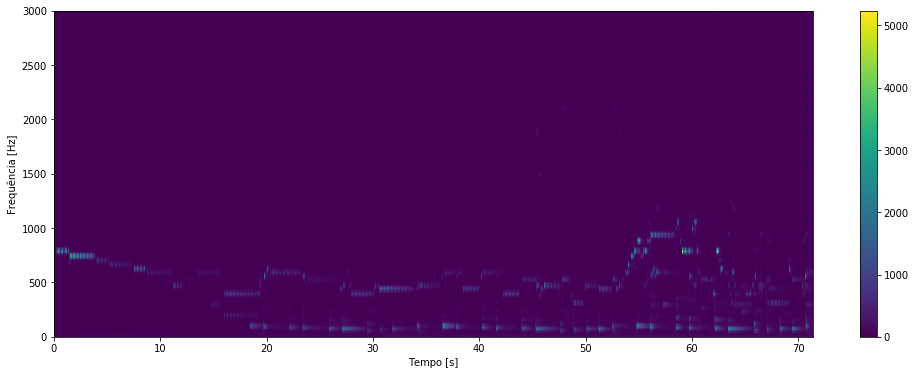

In [3]:
# Vendo o espectrograma
plt.figure(figsize=(17,6));
plt.pcolormesh(t, f, abs(Sx));
plt.ylabel('Frequência [Hz]');
plt.xlabel('Tempo [s]');
plt.ylim(0, 3000);
plt.colorbar();
plt.show();

In [4]:
print("Dimensões de Sx: %dx%d" % (nbins, nframes));
print("Resolução das frequências: " + str(f[1]));

Dimensões de Sx: 2049x6149
Resolução das frequências: 10.7666015625


## Passo 2: Detecção de Picos

Para a detecção de picos eficiente, será usado o método de Estimação de Espectro Estocástico, com $N_{sse} = 301$.

In [5]:
# Geramos uma matriz h[n] para poder executar a convolução circular.
Nsse = 301;
fz = np.zeros((nbins,));

for a in range(Nsse):
    fz[a] = 1/Nsse;

F_sse = np.zeros((nbins,nbins));

F_sse[:, 0] = fz;
for i in range(1, nbins):
    F_sse[:, i] = np.hstack(([F_sse[nbins - 1, i - 1]], F_sse[0:(nbins - 1), i - 1]));

In [35]:
# Definindo uma função para o filtro de média móvel
def running_mean(x, N):
    x = np.hstack(([0], x));
    x = np.hstack((x, [0]));
    cumsum = np.cumsum(np.insert(x, 0, 0));
    return (cumsum[N:] - cumsum[:-N]) / float(N);

def sse(Sk, minimum):
    # Agora, passamos Sk por um filtro média móvel de 3 coeficientes
    # e trocamos valores nulos por valores muito pequenos
    Sk_1 = running_mean(Sk, 3);
    Sk_1 = [x if x != 0 else minimum for x in Sk_1];
    
    # Computamos Rk = 1/Sk_1
    Rk = [1/x for x in Sk_1];
    
    # Fazemos a convolução circular de Rk com um filtro MA de ordem Nsse
    Rk_1 = np.dot(F_sse, Rk);
    
    # Finalmente, retornamos E_sse
    return [1/x for x in Rk_1];


# Definindo alguns parâmetros para as contas
minimum = 10^-15;
height_peaks = 10^4;
P = np.zeros((nbins, nframes));
peak_pos = [];

for i in range(nframes):
    # Primeiramente, calculamos os módulos do frame
    Sk = abs(Sx[:, i]);
    
    # E o limite E_sse
    E_sse = sse(Sk, minimum);
    
    # Corrigindo Sk e detectando os picos
    S = Sk/E_sse;
    peaks, _ = signal.find_peaks(S, height=height_peaks);
    peak_pos.append(peaks);
    
    # Gerando uma matriz apenas com os pontos detectados como picos
    for j in peaks:
        P[j][i] = Sk[j];

In [36]:
argP = np.angle(Sx);
Sp = np.multiply(P, np.cos(argP) + 1j*np.sin(argP));

## Parte 3: Geração das Trilhas

Algotimo de construção das trilhas. Utilizou-se o modelo descrito por McAulay e Quatieri, de acordo com as referências.

In [37]:
D_mq = 5; # Uma trilha pode ficar inativa por no maximo D_mk frames.
K_mq = 10; # Uma trilha precisa ter no minimo K_mk frames de duracao.

class Track(object):
    """Objeto que descreve uma track."""
    
    # Construtor da classe.
    def __init__(self, frel, frame):        
        self.status = 1; # Uma track pode estar inativa (-1), dormindo (0) ou ativa (1).
        self.sleeptime = 0; # A quantos quadros a track esta dormindo.
        self.duration = 1; # A quantos quadros a track existe.
        self.firstframe = frame; # Em que quadro a track comeca.
        self.amplitudes = [np.abs(Sp[frel][frame])]; # Vetor de amplitudes
        self.freqs = [frel]; # Vetor de frequencias relativas
        self.phases = [np.angle(Sp[frel][frame])]; # Vetor de fases
        self.candidates = []; # Candidatos para a nova frequencia
        self.distances = []; # Distancia entre a frequencia anterior e os candidatos
    
    # Metodo que corrige a frequencia atual depois da predicao
    def correctf(self, frel):
        self.freqs[-1] = frel;
    
    # Metodo que adiciona um candidato na lista
    def addcandidate(self, fc, d):
        self.candidates.append(fc);
        self.distances.append(d);
    
    # Metodo que remove um candidato da lista
    def removecandidate(self, fc):
        i = self.candidates.index(fc);
        self.candidates.remove(fc);
        del self.distances[i];
    
    # Metodo que reseta a lista de candidatos
    def resetcandidates(self):
        self.candidates = [];
        self.distances = [];
    
    # Metodo que pega o candidato com a menor distancia da frequencia predita
    def fsmallestd(self):
        i = self.distances.index(min(self.distances));
        return self.candidates[i];
    
    # Metodo que pega a distancia entre um candidato e o valor predito
    def getd(self, fc):
        i = self.candidates.index(fc);
        return self.distances[i];

In [38]:
# Algoritmo de geracao de trilhas. A rigor, precisamos fazer um for
# para cada frame; porem, o primeiro frame e especial, e para nao fazermos
# um (if frame 0) milhares de vezes, vamos trata-lo externamente.

tracks = [];
livetracks = [];
for fi in peak_pos[0]:
    livetracks.append(Track(fi, 0));

for i in range(1, nframes):
    ntracks = len(livetracks);
    peaksv = list(peak_pos[i]);
    
    # Primeiramente, fazemos a predicao das trilhas ativas. Colocaremos todas
    # as trilhas como dormindo ate associarmos um pico
    for t in livetracks:
        t.freqs.append(t.freqs[-1]);
        t.status = 0;
        
    # Agora, fazemos a decisao
    
    # Checando os possiveis candidatos para um pico    
    for t in livetracks:
        for fp in peaksv:
            if abs(fp - t.freqs[-1]) < 0.03*t.freqs[-1]:
                t.addcandidate(fp, abs(fp - t.freqs[-1]));
    
    # Agora, corrigimos possiveis conflitos entre duas tracks
    for track_k in livetracks:
        for track_j in livetracks:
            if track_j == track_k:
                continue;
            
            # Pegamos uma lista de candidatos conflituosos
            xy = list(set(track_k.candidates) & set(track_j.candidates));
            
            # Se d for menor para uma das tracks do que pra outra, removemos o candidato
            # do maior valor
            for a in xy:
                if (a == track_k.fsmallestd() and a != track_j.fsmallestd()):
                    track_j.removecandidate(a);
                elif (a == track_j.fsmallestd() and a != track_k.fsmallestd()):
                    track_k.removecandidate(a);
                else:
                    if (track_j.getd(a) > track_k.getd(a)):
                        track_k.removecandidate(a);
                    else:
                        track_j.removecandidate(a);                    
    # for k in range(ntracks)
    
    for t in livetracks:
        try:
            fn = t.fsmallestd();
            peaksv.remove(fn); # A frequencia fn agora esta associada a track
            t.correctf(fn); # Corrigimos a frequencia atual
            t.duration += 1;
            t.amplitudes.append(np.abs(Sp[fn][i]));
            t.phases.append(np.angle(Sp[fn][i]));
            t.status = 1;
            t.sleeptime = 0;
        except ValueError: # ValueError = trilha nao foi associada a nenhuma freq
            t.sleeptime += 1; # Incrementamos o tempo de dormindo...
            t.duration += 1;  # e de duracao, caso ela volte
            t.amplitudes.append(t.amplitudes[-1]); # A amplitude e a fase serao as
            t.phases.append(t.phases[-1]);         # as mesmas do frame anterior
        
        # Resetamos os candidatos para o proximo frame
        t.resetcandidates();
    
    # Picos que nao foram associados a nenhuma trilha viram novas trilhas
    for fk in peaksv:
        livetracks.append(Track(fk, i));
        
    for t in livetracks:
        if (t.sleeptime > D_mq) or (i == nframes - 1): # Todas sao checadas caso estejamos no ultimo frame
            if (t.duration - t.sleeptime) > K_mq: # A trilha durou tempo o suficiente
                
                # Precisamos jogar fora os ultimos D_mq valores, que foram
                # preditos ao acharmos que a trilha voltaria
                for z in range(D_mq):
                    del t.amplitudes[-1];
                    del t.phases[-1];
                    del t.freqs[-1];
                
                t.status = -1;
                t.duration -= D_mq;
                tracks.append(t);
            
            # Em ambos os casos, tiramos a trilha da lista de trilhas ativas
            livetracks.remove(t);

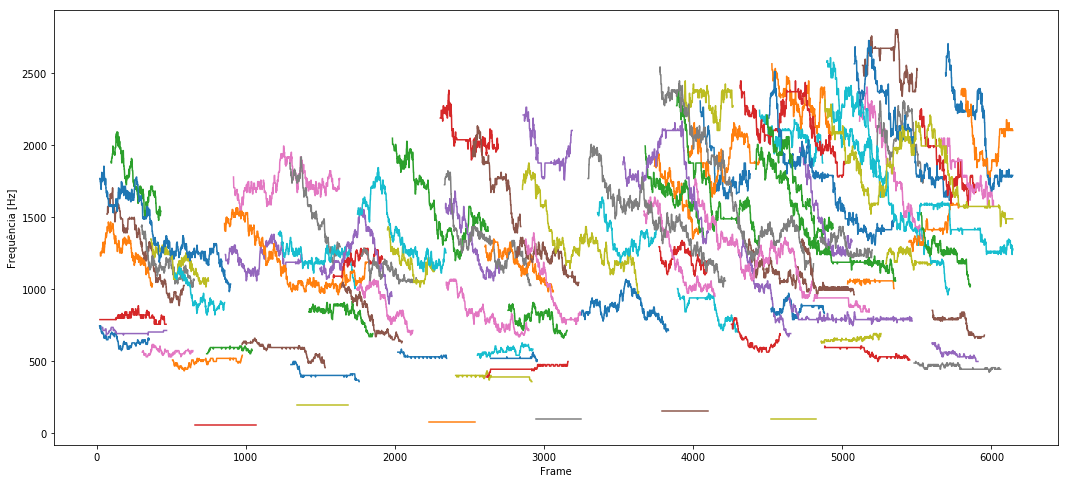

In [52]:
# Plotagem das trilhas; Como temos muitas trilhas, vamos desenhar
# apenas algumas, para termos uma ideia geral

plt.figure(figsize=(18,8));
for i in range(0, len(tracks)):
    t = tracks[i];
    if (t.duration > 300):
        plt.plot(range(t.firstframe, t.firstframe + t.duration), f[1] * np.array(t.freqs));
plt.ylabel('Frequência [Hz]');
plt.xlabel('Frame');
plt.show();

## Parte 4: Síntese

In [ ]:
# Primeiro, iremos gerar um vetor para cada instante de tempo.
# Como temos nframes, cada um distanciado de leapsize, precisamos de um vetor
# total de tamanho nframes*leapsize.

xsyn = np.zeros(nframes*leapsize);

# Agora, para cada track fazemos o processo de interpolacao
for t in tracks:
    first = t.firstframe*leapsize;
    last = (t.firstframe + t.duration - 1)*leapsize;
    
    for m in range(1, t.duration):
        slope = (t.amplitudes[m] - t.amplitudes[m - 1]) / leapsize;
        
        phi_m1 = t.phases[m - 1];
        phi = t.phases[m];
        w_m1 = 2 * np.pi * fmin * t.freqs[m - 1] / Fs;
        w = 2 * np.pi * fmin * t.freqs[m] / Fs;
        try:
            w_p1 = 2 * np.pi * fmin * t.freqs[m + 1] / Fs;
        except ValueError: # Se estivermos no ultimo frame, nao existe w_p1
            w_p1 = 0;
            
        G = int(round(((phi_m1 + w_m1*leapsize - phi) + (w - w_p1) * leapsize / 2 ) / (2 * np.pi)));
        
        alpha = 3 * (phi - phi_m1 - w_m1*leapsize + 2*np.pi*G) / (leapsize ** 2) - (w - w_m1) / leapsize;
        beta = -2 * (phi - phi_m1 - w_m1*leapsize + 2*np.pi*G) / (leapsize ** 3) - (w - w_m1) / (leapsize ** 2);
        
        for n in range(leapsize):
            xsyn[first + leapsize*(m-1) + n] += (t.amplitudes[m - 1] + slope*n) * np.cos(phi_m1 + w_m1*n + alpha*(n**2) + beta*(n**3));

In [ ]:
xsyn = np.asarray(xsyn, dtype=np.int16);
wavfile.write("dido_sintetizado.wav", Fs, xsyn);